# Sector-coupling with `pypsa`

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pypsa pandas numpy matplotlib plotly highspy
```
:::

In [168]:
import pypsa
import pandas as pd
import numpy as np
import plotly.io as pio
import plotly.offline as py
import matplotlib.pyplot as plt
pd.options.plotting.backend = "plotly"

## Previous electricity-only PyPSA model

To explore sector-coupling options with PyPSA, let's load the capacity expansion model we built for the electricity system and add sector-coupling technologies and demands on top. 

Some of the sector-coupling technologies we are going to add have multiple ouputs (e.g. CHP plants producing heat and power). PyPSA can automatically handle links have more than one input (`bus0`)
and/or output (i.e. `bus1`, `bus2`, `bus3`) with a given efficieny (`efficiency`, `efficiency2`, `efficiency3`).

In [169]:
url = "https://tubcloud.tu-berlin.de/s/Rz4iDEQq8DwBd6R/download/electricity-network.nc"
n = pypsa.Network(url)

INFO:pypsa.io:Retrieving network data from https://tubcloud.tu-berlin.de/s/Rz4iDEQq8DwBd6R/download/electricity-network.nc
INFO:pypsa.io:Imported network electricity-network.nc has buses, carriers, generators, global_constraints, loads, storage_units


In [170]:
n

PyPSA Network
Components:
 - Bus: 1
 - Carrier: 6
 - Generator: 4
 - GlobalConstraint: 1
 - Load: 1
 - StorageUnit: 2
Snapshots: 2190

In [171]:
n.buses.index

Index(['electricity'], dtype='object', name='Bus')

In [172]:
n.generators.index

Index(['OCGT', 'onwind', 'offwind', 'solar'], dtype='object', name='Generator')

In [173]:
n.storage_units.index

Index(['battery storage', 'hydrogen storage underground'], dtype='object', name='StorageUnit')

## Hydrogen Production

The following example shows how to model the components of hydrogen storage separately, i.e. electrolysis, fuel cell and storage.

First, let's remove the simplified hydrogen storage representation:

In [174]:
n.remove("StorageUnit", "hydrogen storage underground")

Add a separate `Bus` for the hydrogen energy carrier:

In [175]:
n.add("Bus", "hydrogen", carrier='hydrogen')

Index(['hydrogen'], dtype='object')

Add a `Link` for the hydrogen electrolysis:

In [176]:
n.add(
    "Link",
    "electrolysis",
    bus0="electricity",
    bus1="hydrogen",
    carrier="electrolysis",
    p_nom_extendable=True,
    efficiency=0.7,
    capital_cost=50e3,  # €/MW/a
)

Index(['electrolysis'], dtype='object')

Add a `Link` for the fuel cell which reconverts hydrogen to electricity:

In [177]:
n.add(
    "Link",
    "fuel cell",
    bus0="hydrogen",
    bus1="electricity",
    carrier="fuel cell",
    p_nom_extendable=True,
    efficiency=0.5,
    capital_cost=120e3,  # €/MW/a
)

Index(['fuel cell'], dtype='object')

Add a `Store` for the hydrogen storage:

In [178]:
n.add(
    "Store",
    "hydrogen storage",
    bus="hydrogen",
    carrier="hydrogen storage",
    capital_cost=140,  # €/MWh/a
    e_nom_extendable=True,
    e_cyclic=True,  # cyclic state of charge
)

Index(['hydrogen storage'], dtype='object')

We can also add a hydrogen demand to the hydrogen bus.

In the example below, we add a constant hydrogen demand the size of the electricity demand.

In [179]:
p_set = n.loads_t.p_set["demand"].mean()

In [180]:
p_set

54671.88812785388

In [181]:
n.add("Load", "hydrogen demand", bus="hydrogen", carrier="hydrogen", p_set=p_set)  # MW

Index(['hydrogen demand'], dtype='object')

When we now optimize the model with additional hydrogen demand...

In [182]:
n.optimize()

Index(['hydrogen storage'], dtype='object', name='Store')


Index(['electricity', 'hydrogen'], dtype='object', name='Bus')
Index(['hydrogen demand'], dtype='object', name='Load')
Index(['electrolysis', 'fuel cell'], dtype='object', name='Link')
Index(['hydrogen storage'], dtype='object', name='Store')
Index(['electricity', 'hydrogen'], dtype='object', name='Bus')
Index(['hydrogen demand'], dtype='object', name='Load')
Index(['electrolysis', 'fuel cell'], dtype='object', name='Link')
/home/fneum/miniconda3/envs/nordnet/lib/python3.12/site-packages/linopy/common.py:147: UserWarning:

coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 356.19it/s]
INFO:linopy.io: Writing time: 0.25s
INFO:linopy.solvers:Log file at /tm

Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-04, 6e+00]
  Cost   [4e-02, 2e+05]
  Bound  [0e+00, 0e+00]
  RHS    [3e+04, 8e+04]
Presolving model
27420 rows, 20857 cols, 73500 nonzeros  0s
25230 rows, 18667 cols, 69120 nonzeros  0s
Presolve : Reductions: rows 25230(-27343); columns 18667(-5431); elements 69120(-45908)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 4380(8.00224e+09) 0s
      21709     8.6257637671e+10 Pr: 4288(6.54421e+10); Du: 0(1.48241e-08) 5s
      26444     9.4542662147e+10 Pr: 0(0); Du: 0(2.40086e-14) 7s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 26444
Objective value     :  9.4542662147e+10
HiGHS run time      :          7.14
Writing the solution to /tmp/linopy-solve-slmbt79s.sol


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 24098 primals, 52573 duals
Objective: 9.45e+10
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

... we get an additional price time series for the hydrogen "market",

In [183]:
n.buses_t.marginal_price.plot()

and can see the individual sizing of the electrolyser, fuel cell and hydrogen storage:

In [184]:
n.statistics.expanded_capacity().div(1e3).round(1)

component    carrier         
StorageUnit  battery storage        65.1
Store        hydrogen storage    41979.1
Link         electrolysis          183.3
             fuel cell              71.3
Generator    offwind               179.2
             onwind                 80.3
             solar                 480.3
dtype: float64

Furthermore, we might want to explore the storage state of charge of the hydrogen storage and the balancing patterns:

In [185]:
n.stores_t.e.plot()

## Heat Demand

For modelling simple heating systems, we create another bus and connect a load with the heat demand time series to it:

In [186]:
n.add("Bus", "heat", carrier='heat')

Index(['heat'], dtype='object')

In [187]:
url = "https://tubcloud.tu-berlin.de/s/mSkHERH8fJCKNXx/download/heat-load-example.csv"
p_set = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()

In [188]:
p_set.head()

snapshot
2015-01-01 00:00:00     61726.043437
2015-01-01 04:00:00    108787.133591
2015-01-01 08:00:00    101508.988082
2015-01-01 12:00:00     90475.260586
2015-01-01 16:00:00     96307.755312
Name: 0, dtype: float64

In [189]:
n.add("Load", "heat demand", carrier="heat", bus="heat", p_set=p_set)

Index(['heat demand'], dtype='object')

In [190]:
n.loads_t.p_set.div(1e3).plot()

What is now missing are a few heat supply options...

## Heat pumps

To model heat pumps, first we have to calculate the **coefficient of performance (COP)** profile based on the temperature profile of the heat source.

In the example below, we calculate the COP for an air-sourced heat pump with a sink temperature of 55° C and a population-weighted ambient temperature profile for Germany.

The heat pump performance is assumed to be given by the following function:

$$
COP(\Delta T) = 6.81 - 0.121 \Delta T + 0.00063^\Delta T^2
$$
where $\Delta T = T_{sink} - T_{source}$.

In [191]:
def cop(t_source, t_sink=55):
    delta_t = t_sink - t_source
    return 6.81 - 0.121 * delta_t + 0.000630 * delta_t**2

In [193]:
url = "https://tubcloud.tu-berlin.de/s/S4jRAQMP5Te96jW/download/ninja_weather_country_DE_merra-2_population_weighted.csv"
temp = pd.read_csv(url, skiprows=2, index_col=0, parse_dates=True).loc[
    "2015", "temperature"
][::4]

In [194]:
cop(temp).plot()

Text(0, 0.5, 'COP [-]')

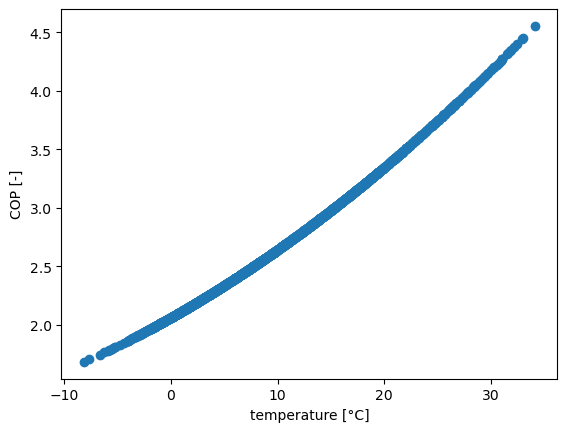

In [195]:
plt.scatter(temp, cop(temp))
plt.xlabel("temperature [°C]")
plt.ylabel("COP [-]")

Once we have calculated the heat pump coefficient of performance, we can add the heat pump to the network as a `Link`. We use the parameter `efficiency` to incorporate the COP.

In [196]:
n.add(
    "Link",
    "heat pump",
    carrier="heat pump",
    bus0="electricity",
    bus1="heat",
    efficiency=cop(temp),
    p_nom_extendable=True,
    capital_cost=3e5,  # €/MWe/a
)

Index(['heat pump'], dtype='object')

Let's also add a resistive heater as backup technology:

In [197]:
n.add(
    "Link",
    "resistive heater",
    carrier="resistive heater",
    bus0="electricity",
    bus1="heat",
    efficiency=0.9,
    capital_cost=1e4,  # €/MWe/a
    p_nom_extendable=True,
)

Index(['resistive heater'], dtype='object')

## Combined Heat-and-Power (CHP)

In the following, we are going to add gas-fired combined heat-and-power plants (CHPs). Today, these would use fossil gas, but in the example below we assume imported green methane or methanol with relatively high marginal costs. Since we have no other net emission technology, we can remove the CO$_2$ limit.

In [198]:
n.remove("GlobalConstraint", "CO2Limit")

Then, we explicitly represent the energy carrier gas:

In [199]:
n.add("Bus", "gas", carrier="gas")

Index(['gas'], dtype='object')

And add a `Store` of gas, which can be depleted (up to 100 TWh) with fuel costs of 180 €/MWh.

In [200]:
n.add(
    "Store",
    "gas storage",
    carrier="gas storage",
    e_initial=100e6,  # MWh
    e_nom=100e6,  # MWh
    bus="gas",
    marginal_cost=180,  # €/MWh_th
)

Index(['gas storage'], dtype='object')

When we do this, we have to model the OCGT power plant as link which converts gas to electricity, not as generator.

In [201]:
n.remove("Generator", "OCGT")

In [202]:
n.add(
    "Link",
    "OCGT",
    bus0="gas",
    bus1="electricity",
    carrier="OCGT",
    p_nom_extendable=True,
    capital_cost=20000,  # €/MW/a
    efficiency=0.4,
)

Index(['OCGT'], dtype='object')

Next, we are going to add a combined heat-and-power (CHP) plant with fixed heat-power ratio (i.e. backpressure operation).

:::{note}
If you want to model flexible heat-power ratios, have a look at this example: https://pypsa.readthedocs.io/en/latest/examples/power-to-gas-boiler-chp.html
:::

In [203]:
n.add(
    "Link",
    "CHP",
    bus0="gas",
    bus1="electricity",
    bus2="heat",
    carrier="CHP",
    p_nom_extendable=True,
    capital_cost=40000,
    efficiency=0.4,
    efficiency2=0.4,
)

Index(['CHP'], dtype='object')

Now, let's optimize the current status of model:

In [204]:
n.optimize()

Index(['hydrogen storage', 'gas storage'], dtype='object', name='Store')


Index(['electricity', 'hydrogen', 'heat', 'gas'], dtype='object', name='Bus')
Index(['hydrogen demand', 'heat demand'], dtype='object', name='Load')
Index(['electrolysis', 'fuel cell', 'heat pump', 'resistive heater', 'CHP'], dtype='object', name='Link')
Index(['hydrogen storage', 'gas storage'], dtype='object', name='Store')
Index(['electricity', 'hydrogen', 'heat', 'gas'], dtype='object', name='Bus')
Index(['hydrogen demand', 'heat demand'], dtype='object', name='Load')
Index(['electrolysis', 'fuel cell', 'heat pump', 'resistive heater', 'CHP'], dtype='object', name='Link')
/home/fneum/miniconda3/envs/nordnet/lib/python3.12/site-packages/linopy/common.py:147: UserWarning:

coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objecti

Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35051 primals, 76664 duals
Objective: 1.43e+11
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


  Matrix [1e-04, 6e+00]
  Cost   [4e-02, 3e+05]
  Bound  [0e+00, 0e+00]
  RHS    [2e+04, 1e+08]
Presolving model
42749 rows, 34000 cols, 119487 nonzeros  0s
38370 rows, 29621 cols, 110729 nonzeros  0s
Presolve : Reductions: rows 38370(-38294); columns 29621(-5430); elements 110729(-50291)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      18227     2.9864576475e+10 Pr: 8872(5.4273e+12); Du: 0(8.27947e-07) 5s
      24174     7.4419421103e+10 Pr: 19639(2.40211e+13); Du: 0(7.68579e-08) 10s
      29363     1.2510095433e+11 Pr: 3375(9.30095e+10) 16s
      33878     1.4301664789e+11 Pr: 0(0); Du: 0(3.73035e-14) 20s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 33878
Objective value     :  1.4301664789e+11
HiGHS run time      :         19.87
Writing the solution to /tmp/linopy-solve-gx7blaz1.sol


('ok', 'optimal')

The objective cost in bn€/a:

In [205]:
n.objective / 1e9

143.01664789325199

The heat energy balance (positive is supply, negative is consumption):

In [206]:
n.statistics.energy_balance(bus_carrier='heat').div(1e6).round(1)

component  carrier           bus_carrier
Load       heat              heat          -593.7
Link       heat pump         heat           519.1
           resistive heater  heat            34.6
           CHP               heat            40.0
dtype: float64

The heat energy balance as a time series:

In [207]:
n.statistics.energy_balance(aggregate_time=False, bus_carrier='heat').div(1e3).groupby("carrier").sum().T.plot()

The price time series:

In [208]:
n.buses_t.marginal_price.plot()

## Long-duration heat storage

One technology of particular interest in district heating systems with large shares of renewables is long-duration thermal energy storage.

In the following, we are going to introduce a heat storage with investment cost of approximately 3 €/kWh.
The energy is not perfectly stored in water tanks. There are standing losses.
The decay of thermal energy in the heat storage is modelled through the function $1 - e^{-\frac{1}{24\tau}}$, where $\tau$ is assumed to be 180 days.
We want to see how that influences the optimal design decisions in the heating sector.

In [209]:
n.add(
    "Store",
    "heat storage",
    bus="heat",
    carrier="heat storage",
    capital_cost=300, # roughly annuity of 3 €/kWh
    standing_loss=1 - np.exp(-1 / 24 / 180),
    e_nom_extendable=True,
)

Index(['heat storage'], dtype='object')

In [210]:
n.optimize()

Index(['hydrogen storage', 'gas storage', 'heat storage'], dtype='object', name='Store')
Index(['electricity', 'hydrogen', 'heat', 'gas'], dtype='object', name='Bus')
Index(['hydrogen demand', 'heat demand'], dtype='object', name='Load')
Index(['electrolysis', 'fuel cell', 'heat pump', 'resistive heater', 'CHP'], dtype='object', name='Link')


Index(['hydrogen storage', 'gas storage', 'heat storage'], dtype='object', name='Store')
Index(['electricity', 'hydrogen', 'heat', 'gas'], dtype='object', name='Bus')
Index(['hydrogen demand', 'heat demand'], dtype='object', name='Load')
Index(['electrolysis', 'fuel cell', 'heat pump', 'resistive heater', 'CHP'], dtype='object', name='Link')
/home/fneum/miniconda3/envs/nordnet/lib/python3.12/site-packages/linopy/common.py:147: UserWarning:

coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 258.82it/s]
INFO:linopy.io: Writing time: 0.38s
INFO:linopy.solvers:Log file at /tmp/highs.log


Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-04, 6e+00]
  Cost   [4e-02, 3e+05]
  Bound  [0e+00, 0e+00]
  RHS    [2e+04, 1e+08]
Presolving model
47128 rows, 38380 cols, 132624 nonzeros  0s
40560 rows, 31812 cols, 119488 nonzeros  0s
40560 rows, 31812 cols, 119488 nonzeros  0s
Presolve : Reductions: rows 40560(-42675); columns 31812(-7620); elements 119488(-56862)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      18112     7.6761941973e+09 Pr: 8644(2.77992e+13); Du: 0(1.11832e-06) 5s
      25704     4.3746995472e+10 Pr: 6556(2.16094e+13); Du: 0(5.2048e-07) 11s
      30720     6.1630766295e+10 Pr: 11537(1.893e+15); Du: 0(5.24728e-07) 16s
      35273     9.4790836361e+10 Pr: 16860(3.74283e+13) 21s
      39356     1.0987535619e+11 Pr: 13183(5.23669e+12) 26s
      43659     1.2746950391e+11 P

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 39432 primals, 83235 duals
Objective: 1.33e+11
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


: 0(2.57727e-12) 35s
      47147     1.3341557805e+11 Pr: 0(0); Du: 0(2.57727e-12) 35s
      47147     1.3341557805e+11 Pr: 0(0); Du: 0(2.57727e-12) 35s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 47147
Objective value     :  1.3341557805e+11
HiGHS run time      :         35.00
Writing the solution to /tmp/linopy-solve-j1xki718.sol


('ok', 'optimal')

The objective cost (in bn€/a) was reduced by 7%!

In [212]:
n.objective / 1e9

133.41557805470643

The heat energy balance shows the additional losses of the heat storage and the added supply:

In [214]:
n.statistics.energy_balance(bus_carrier='heat').div(1e6).round(1)

component  carrier           bus_carrier
Load       heat              heat          -593.7
Store      heat storage      heat           -11.7
Link       heat pump         heat           499.2
           resistive heater  heat            82.3
           CHP               heat            23.8
dtype: float64

The heat energy balance as a time series:

In [215]:
n.statistics.energy_balance(aggregate_time=False, bus_carrier='heat').div(1e3).groupby("carrier").sum().T.plot()

The heat price time series is much less impacted by the variability of the electricity price: 

In [216]:
n.buses_t.marginal_price.plot()

The different storage state of charge time series:

In [217]:
n.stores_t.e.plot()

## Electric Vehicles

To model electric vehicles, we first create another bus for the electric vehicles.

In [218]:
n.add("Bus", "EV", carrier="EV")

Index(['EV'], dtype='object')

Then, we can attach the electricity consumption of electric vehicles to this bus:

In [219]:
url = "https://tubcloud.tu-berlin.de/s/9r5bMSbzzQiqG7H/download/electric-vehicle-profile-example.csv"
p_set = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()

In [222]:
p_set.loc["2015-01"].div(1e3).plot()

In [223]:
n.add("Load", "EV demand", bus="EV", carrier="EV demand", p_set=p_set)

Index(['EV demand'], dtype='object')

The electric vehicles can only be charged when they are plugged-in. Below we load an availability profile
telling us what share of electric vehicles is plugged-in **at home** -- we only assume home charging in this example.

In [225]:
url = "https://tubcloud.tu-berlin.de/s/E3PBWPfYaWwCq7a/download/electric-vehicle-availability-example.csv"
availability_profile = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()

In [228]:
availability_profile.loc["2015-01"].plot()

Then, we can add a link for the electric vehicle charger using assumption about the number of EVs and their charging rates.

In [229]:
number_cars = 40e6  #  number of EV cars
bev_charger_rate = 0.011  # 3-phase EV charger with 11 kW
p_nom = number_cars * bev_charger_rate

In [230]:
n.add(
    "Link",
    "EV charger",
    bus0="electricity",
    bus1="EV",
    p_nom=p_nom,
    carrier="EV charger",
    p_max_pu=availability_profile,
    efficiency=0.9,
)

Index(['EV charger'], dtype='object')

We can also allow vehicle-to-grid operation (i.e. electric vehicles inject power into the grid):

In [231]:
n.add(
    "Link",
    "V2G",
    bus0="EV",
    bus1="electricity",
    p_nom=p_nom,
    carrier="V2G",
    p_max_pu=availability_profile,
    efficiency=0.9,
)

Index(['V2G'], dtype='object')

The demand-side management potential we model as a store. This is not unlike a battery storage, but we impose additional constraints on when the store needs to be charged to a certain level (e.g. 75% full every morning).

In [232]:
bev_energy = 0.05  # average battery size of EV in MWh
bev_dsm_participants = 0.5  # share of cars that do smart charging

e_nom = number_cars * bev_energy * bev_dsm_participants

In [243]:
url = "https://tubcloud.tu-berlin.de/s/K62yACBRTrxLTia/download/dsm-profile-example.csv"
dsm_profile = pd.read_csv(url, index_col=0, parse_dates=True).squeeze().shift(2).fillna(0)[::4]

In [247]:
dsm_profile.loc["2015-01-01":"2015-01-07"].plot()

In [248]:
n.add(
    "Store",
    "EV DSM",
    bus="EV",
    carrier="EV battery",
    e_cyclic=True,  # state of charge at beginning = state of charge at the end
    e_nom=e_nom,
    e_min_pu=dsm_profile,
)

Index(['EV DSM'], dtype='object')

Then, we can solve the fully sector-coupled model altogether including electricity, passenger transport, hydrogen and heating.

In [249]:
n.optimize(solver_name="highs")

Index(['hydrogen storage', 'gas storage', 'heat storage', 'EV DSM'], dtype='object', name='Store')
Index(['electricity', 'hydrogen', 'heat', 'gas', 'EV'], dtype='object', name='Bus')
Index(['hydrogen demand', 'heat demand', 'EV demand'], dtype='object', name='Load')
Index(['electrolysis', 'fuel cell', 'heat pump', 'resistive heater', 'CHP',
       'EV charger', 'V2G'],
      dtype='object', name='Link')
Index(['hydrogen storage', 'gas storage', 'heat storage', 'EV DSM'], dtype='object', name='Store')
Index(['electricity', 'hydrogen', 'heat', 'gas', 'EV'], dtype='object', name='Bus')
Index(['hydrogen demand', 'heat demand', 'EV demand'], dtype='object', name='Load')
Index(['electrolysis', 'fuel cell', 'heat pump', 'resistive heater', 'CHP',
       'EV charger', 'V2G'],
      dtype='object', name='Link')
/home/fneum/miniconda3/envs/nordnet/lib/python3.12/site-packages/linopy/common.py:147: UserWarning:

coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previous

Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-04, 6e+00]
  Cost   [4e-02, 3e+05]
  Bound  [0e+00, 0e+00]
  RHS    [2e+03, 1e+08]
Presolving model
51508 rows, 47140 cols, 150144 nonzeros  0s
42750 rows, 38382 cols, 132628 nonzeros  0s
42750 rows, 38382 cols, 132628 nonzeros  0s
Presolve : Reductions: rows 42750(-58005); columns 38382(-9810); elements 132628(-74382)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      20489     7.0209292127e+09 Pr: 10189(7.06301e+14); Du: 0(9.85806e-07) 5s
      26917     3.1666331621e+10 Pr: 6630(2.35325e+13); Du: 0(6.23236e-07) 11s
      32263     3.2859044901e+10 Pr: 7443(6.50205e+13); Du: 0(2.8441e-07) 16s
      36620     5.3585544208e+10 Pr: 10737(1.8223e+13); Du: 0(4.035e-07) 21s
      40843     8.8898698525e+10 Pr: 15887(1.50189e+15); Du: 0(7.42276e-07)

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 48192 primals, 100755 duals
Objective: 1.37e+11
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

A very general overview is given with a call to `n.statistics()`:

In [251]:
n.statistics()

Optimal Capacity  Installed Capacity  \
Generator offwind               2.455913e+05                 0.0   
          onwind                1.575662e+05                 0.0   
          solar                 5.033996e+05                 0.0   
Link      CHP                   1.123002e+05                 0.0   
          EV charger            4.400000e+05            440000.0   
          OCGT                  6.770876e+03                 0.0   
          V2G                   4.400000e+05            440000.0   
          electrolysis          1.579354e+05                 0.0   
          heat pump             4.444094e+04                 0.0   
          resistive heater      9.724606e+04                 0.0   
Load      -                     0.000000e+00                 0.0   
          EV demand             0.000000e+00                 0.0   
          heat                  0.000000e+00                 0.0   
          hydrogen              0.000000e+00                 0.0   
Store     EV battery            1.000000e+06           1000000.0   
          gas storage           1.000000e+08         100000000.0   
          heat storage          1.270014e+07                 0.0   
          hydrogen storage      6.532086e+07                 0.0   

                                  Supply    Withdrawal  Energy Balance  \
Generator offwind           7.805015e+08  0.000000e+00    7.805015e+08   
          onwind            2.659010e+08  0.000000e+00    2.659010e+08   
          solar             5.476326e+08  0.000000e+00    5.476326e+08   
Link      CHP               5.083544e+07  6.354431e+07   -1.270886e+07   
          EV charger        2.000217e+08  2.222463e+08   -2.222463e+07   
          OCGT              3.536607e+05  8.841518e+05   -5.304911e+05   
          V2G               6.816967e+07  7.574408e+07   -7.574408e+06   
          electrolysis      4.789257e+08  6.841796e+08   -2.052539e+08   
          heat pump         4.804672e+08  1.924107e+08    2.880565e+08   
          resistive heater  9.919236e+07  1.102137e+08   -1.102137e+07   
Load      -                 0.000000e+00  4.789257e+08   -4.789257e+08   
          EV demand         0.000000e+00  1.242776e+08   -1.242776e+08   
          heat              0.000000e+00  5.936692e+08   -5.936692e+08   
          hydrogen          0.000000e+00  4.789257e+08   -4.789257e+08   
Store     EV battery        1.290614e+08  1.290614e+08    0.000000e+00   
          gas storage       6.442846e+07  0.000000e+00    6.442846e+07   
          heat storage      1.953699e+08  2.067779e+08   -1.140802e+07   
          hydrogen storage  2.009489e+08  2.009489e+08    0.000000e+00   

                            Transmission  Capacity Factor   Curtailment  \
Generator offwind                    0.0         0.362791  0.000000e+00   
          onwind                     0.0         0.192643  1.808124e+07   
          solar                      0.0         0.124186  0.000000e+00   
Link      CHP                        0.0         0.064594  0.000000e+00   
          EV charger                 0.0         0.057660  0.000000e+00   
          OCGT                       0.0         0.014907  0.000000e+00   
          V2G                        0.0         0.019651  0.000000e+00   
          electrolysis               0.0         0.494523  0.000000e+00   
          heat pump                  0.0         0.494244  0.000000e+00   
          resistive heater           0.0         0.129378  0.000000e+00   
Load      -                          0.0              NaN  0.000000e+00   
          EV demand                  0.0              NaN  0.000000e+00   
          heat                       0.0              NaN  0.000000e+00   
          hydrogen                   0.0              NaN  0.000000e+00   
Store     EV battery                 0.0         0.726787  0.000000e+00   
          gas storage                0.0         0.499883  0.000000e+00   
          heat storage               0.0         0.44

And it can tell you statistics about the capital expenditures:

In [254]:
n.statistics.capex().groupby("carrier").sum().div(1e9).sort_values().dropna().plot.bar()

## Exercises

Explore how the model reacts to changing assumptions and available technologies. Here are a few inspirations, but choose in any order according to your interests:

- By how much did the optimised capacities react to 
- Assume underground hydrogen storage is not geographically available. Increase the cost of hydrogen storage by factor 10. How does the model react?
- Add a ground-sourced heat pump with a constant COP function of 3.5 but double the investment costs. Would this technology get built? How low would the costs need to be?
- Vary the charging rates and availability profiles of electric vehicles, and whether they participate in demand-side management (V2G, smart charging) or not. How does it affect the system design?
- Limit green gas imports to 10 TWh. What does the model do in periods with persistent low wind and solar feed-in but high heating demand?

You can also combine these aspects with investigations suggested for the electricity-only model.